# Make money in stocks

## Part 4: Stock Selection & Q learning—Q Reinforcment Learning

For each selected company: 'ADM','AAPL','CHD','CTAS', we train a best policy based on the historical close prices five years ago(except the recent three months, i.e 2017-10-01 to 2022-08-26), and use this policy as our initial policy for our test on close prices of the recent 3 months(2022-8-27 to 2022-11-27). With an initial capital fund of 10000, we first assign the fund for each company, then we compare our reward with baseline reward for each company.

### Import packages

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import random
import pandas as pd
import math

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


### Step 1: Import stock data which can be found on https://finance.yahoo.com.

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
sp500["Symbol"] = sp500["Symbol"].str.replace(".", "-", regex=True)
sectors=sp500['GICS Sector'].unique()[0:5]
sp50=sp500[sp500['GICS Sector'].isin(sectors)]
sp50=sp50[sp50['Date first added']<'2017-01-01']
sp50=sp50[0:50]
company_symbol=sp50['Symbol'].tolist()
sp50_data=yf.download(tickers=company_symbol,start="2017-10-01",group_by='ticker')

[*********************100%***********************]  50 of 50 completed


### Step 2: Construct Random Decision Policy (to be compared).

Random Decision Policy enables the agent to try random actions for given states to explore the environment and map actions to rewards.

In [4]:
class DecisionPolicy:
    def select_action(self, current_state, step):
        pass
    def update_q(self, state, action, reward, next_state):
        pass

In [5]:
class RandomDecisionPolicy(DecisionPolicy):
    def __init__(self, actions):
        self.actions = actions
    def select_action(self, current_state,step):
        action = random.choice(self.actions)
        return action

### Step 3: Construct Simulation Function.

The Simulation Function obtains the current state and calls the select_actions function from Decision Policy function. This returns the action "Buy", "Sell" or "Hold". Based on the action the budget and portfolio is updated. The next state is found and the policy is updated using the q function. This is repeated for the length of the data minus the history minus 1. The final portfolio,policy and actions of the simulation is then returned.

In [6]:
def run_simulation(policy,initial_budget,initial_num_stocks,prices, hist):
    budget = initial_budget
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = []
    actions=[]
    for i in range(len(prices) - hist - 1):
            current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget,num_stocks)))
            current_portfolio = budget + num_stocks * share_value
            action = policy.select_action(current_state, i)
            share_value = float(prices[i + hist])
            
            if action == 'Buy' and budget >= share_value:
                budget -= share_value
                num_stocks += 1
            elif action == 'Sell' and num_stocks > 0:
                budget += share_value
                num_stocks -= 1
            else:
                action = 'Hold'
            new_portfolio = budget + num_stocks * share_value
            reward = new_portfolio - current_portfolio
            next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget,num_stocks)))
            transitions.append((current_state, action, reward, next_state))
            policy.update_q(current_state, action, reward, next_state)
            actions.append(action)
    portfolio = budget + num_stocks * share_value
    
    print('${}\t{} shares'.format(budget, num_stocks))
    print(portfolio)
    return portfolio,policy,actions

### Step 4: The Result of Random Decision Policy.

Below is an implementation of the Q learning function only choosing random actions. It is clear that the net worth will not increase with just random actions.

In [7]:
actions = ['Buy', 'Sell', 'Hold']
hist = 3
prices=sp50_data['ADM']['Close']['2017-10-01':'2022-08-26']
policy = RandomDecisionPolicy(actions)
budget = 10000*0.111
num_stocks = 0
run_simulation(policy, budget, num_stocks, prices, hist)

$588.7299633026123	7 shares
1225.099988937378


(1225.099988937378,
 ['Hold',
  'Buy',
  'Hold',
  'Buy',
  'Buy',
  'Sell',
  'Buy',
  'Sell',
  'Buy',
  'Sell',
  'Sell',
  'Sell',
  'Hold',
  'Hold',
  'Buy',
  'Hold',
  'Hold',
  'Buy',
  'Sell',
  'Sell',
  'Hold',
  'Buy',
  'Buy',
  'Hold',
  'Hold',
  'Buy',
  'Hold',
  'Hold',
  'Hold',
  'Sell',
  'Sell',
  'Sell',
  'Hold',
  'Hold',
  'Hold',
  'Buy',
  'Hold',
  'Buy',
  'Buy',
  'Hold',
  'Sell',
  'Sell',
  'Buy',
  'Hold',
  'Sell',
  'Hold',
  'Buy',
  'Sell',
  'Sell',
  'Hold',
  'Buy',
  'Hold',
  'Buy',
  'Buy',
  'Sell',
  'Hold',
  'Sell',
  'Sell',
  'Hold',
  'Buy',
  'Buy',
  'Buy',
  'Buy',
  'Sell',
  'Buy',
  'Sell',
  'Buy',
  'Buy',
  'Sell',
  'Sell',
  'Sell',
  'Buy',
  'Sell',
  'Sell',
  'Buy',
  'Hold',
  'Sell',
  'Sell',
  'Hold',
  'Hold',
  'Hold',
  'Hold',
  'Buy',
  'Hold',
  'Buy',
  'Sell',
  'Sell',
  'Hold',
  'Hold',
  'Hold',
  'Hold',
  'Hold',
  'Hold',
  'Hold',
  'Hold',
  'Hold',
  'Buy',
  'Hold',
  'Hold',
  'Buy',
  'Hold',
 

### Step 5: Construct QLearing Decision Policy.

The QLearingDecisionPolicy class maps the inputs to actions using a neural network. It also updates the q values.
The actions are choosen based on the exploration/explotation principle. The actions are random to begin with but as the steps increase the actions that will yield the highest q value for that state. The action q values are calculated through the neural network. The max action q value is choosen and the action returned.

The update_q function preforms the bellman equation and updates the weights in the nerual network. The current state q value and next state q value is obtained from the nerual network. The current q value is updated using the bellman equation. Q(s,a) = R + gamma(arg_max(Q(s',a'))).

The weights are then updated using the loss function Adagrad Optimizier. This will allow the agent to obtain a more accurate Q value given the states and therefore chose an action which will maximize long term reward. 

In [8]:
class QLearningDecisionPolicy(DecisionPolicy):
    def __init__(self, actions, input_dim):
        
        self.epsilon = 0.95
        self.gamma = 0.3
        self.actions = actions
        output_dim = len(actions)
        h1_dim = 20
        
        self.x = tf.placeholder(tf.float32, [None, input_dim])
        self.y = tf.placeholder(tf.float32, [output_dim])
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        self.q = tf.nn.relu(tf.matmul(h1, W2) + b2)

        loss = tf.square(self.y - self.q)
        self.train_op = tf.train.AdagradOptimizer(0.001).minimize(loss)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step / 900.)
        if random.random() < threshold:
            #Choose best possible action
            action_q_vals = self.sess.run(self.q, feed_dict={self.x:current_state})
            action_idx = np.argmax(action_q_vals)
            #action_idx = np.argmin(action_q_vals)
            action = self.actions[action_idx]
           
        else:
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action
    
    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x:next_state})
        next_action_idx = np.argmax(next_action_q_vals)
        #next_action_idx = np.argmin(next_action_q_vals)
        current_action_idx = self.actions.index(action)
        action_q_vals[0, current_action_idx] = reward + self.gamma *next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y:action_q_vals})

### Step 6: Train-Test Split.

In [9]:
stocks=['ADM','AAPL','CHD','CTAS']
weights=[0.111,0.528,0.219,0.142]

In [10]:
def train_test_split(stock_name):
    stock=sp50_data[stock_name]
    prices = stock.iloc[:,3].values
    train_prices=stock.iloc[:,3]['2017-10-01':'2022-08-26'].values
    test_prices=stock.iloc[:,3]['2022-08-27':'2022-11-27'].values
    return train_prices,test_prices

### Step 6: Training and Back Test.

For each company, we simulate 20 times on the training set and choose the policy with the best performance.

In [11]:
def get_best_policy(stock_name):
    train_prices,test_prices=train_test_split(stock_name)
    num_simulation=20
    actions = ['Sell', 'Buy', 'Hold']
    hist = 3
    budget = 10000*weights[stocks.index(stock_name)]
    num_stocks = 0

    portfolios=[]
    policies=[]
    for i in range(num_simulation):
        policy=QLearningDecisionPolicy(actions,hist+2)
        portfolio,policy=run_simulation(policy,budget,num_stocks,train_prices,hist)[0:2]
        portfolios.append(portfolio)
        policies.append(policy)
    best_portfolios=max(portfolios)
    best_policy=policies[portfolios.index(max(portfolios))]
    return best_policy,best_portfolios

### Step 7: Test.

With an initial capital fund of 10000, we compared our reward with baseline reward for each company (The baseline policy is to use all capital fund for the company to buy stocks at first, then sell them all out in the end).

In [12]:
stock_name=stocks[0]
best_policy=get_best_policy(stock_name)[0]

test_prices=train_test_split(stock_name)[1]
actions = ['Sell', 'Buy', 'Hold']
hist = 3
budget = 10000*weights[stocks.index(stock_name)]
num_stocks = 0
portfolio,policy,actions=run_simulation(best_policy, budget, num_stocks, test_prices, hist)
print(portfolio)
print(actions)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
$57.550004959106445	25 shares
2330.300096511841
$1124.1500244140625	0 shares
1124.1500244140625
$11.900020599365234	26 shares
2375.560115814209
$767.3699645996094	11 shares
1767.3800048828125
$1062.2000122070312	0 shares
1062.2000122070312
$11.219985961914062	26 shares
2374.880081176758
$1081.800012588501	0 shares
1081.800012588501
$1153.1000137329102	0 shares
1153.1000137329102
$1115.8800239562988	0 shares
1115.8800239562988
$919.8999519348145	5 shares
1374.4499702453613
$1139.5100135803223	0 shares
1139.5100135803223
$351.1699733734131	14 shares
1623.9100246429443
$740.6600017547607	14 shares
2013.400053024292
$519.2899875640869	15 shares
1882.9400424957275
$110.20993995666504	25 shares
2382.9600315093994
$1149.8699989318848	0 shares
1149.8699989318848
$1134.940034866333	0 shares
1134.940034866333
$4.149955749511719	12 shares
1095.0699996948242
$1115.4799690246582	0 s

base line reward is 79.67999267578125
Q-learning reward is -7.030006408691406


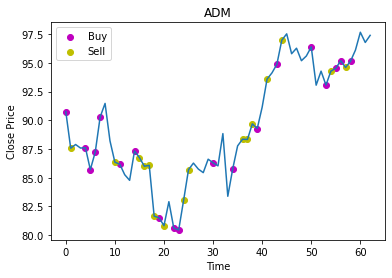

In [13]:
buy_index=[index for index,value in enumerate(actions) if value=='Buy']
sell_index=[index for index,value in enumerate(actions) if value=='Sell']
plt.plot(test_prices)
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(stock_name)
plt.scatter(buy_index,test_prices[buy_index],c='m',label='Buy')
plt.scatter(sell_index,test_prices[sell_index],c='y',label='Sell')
plt.legend()
baseline_reward=(test_prices[-1]-test_prices[0])*math.floor(budget/test_prices[0])
qlearning_reward=portfolio-budget
print(f'base line reward is {baseline_reward}')
print(f'Q-learning reward is {qlearning_reward}')

In [14]:
stock_name=stocks[1]
best_policy=get_best_policy(stock_name)[0]
test_prices=train_test_split(stock_name)[1]
actions = ['Sell', 'Buy', 'Hold']
hist = 3
budget = 10000*weights[stocks.index(stock_name)]
num_stocks = 0
portfolio,policy,actions=run_simulation(best_policy, budget, num_stocks, test_prices, hist)
print(portfolio)
print(actions)

$4648.837490081787	13 shares
6859.2274742126465
$26.857479095458984	110 shares
18730.157344818115
$34.41495132446289	78 shares
13296.75485610962
$27.265003204345703	113 shares
19240.654865264893
$4564.535053253174	13 shares
6774.925037384033
$56.804931640625	112 shares
19100.164794921875
$3870.9825286865234	24 shares
7951.702499389648
$5307.574993133545	0 shares
5307.574993133545
$1035.862461090088	89 shares
16168.53235244751
$5276.317485809326	0 shares
5276.317485809326
$5333.4975662231445	0 shares
5333.4975662231445
$5294.857433319092	0 shares
5294.857433319092
$5356.260021209717	0 shares
5356.260021209717
$6695.299964904785	0 shares
6695.299964904785
$12.469989776611328	111 shares
18885.799854278564
$5304.387504577637	0 shares
5304.387504577637
$5340.457530975342	0 shares
5340.457530975342
$5568.042526245117	12 shares
7608.40251159668
$4623.677505493164	27 shares
9214.48747253418
$5296.297462463379	0 shares
5296.297462463379
$4689.800003051758	4 shares
5294.080032348633
5294.0800323

base line reward is -424.64013671875
Q-learning reward is 14.080032348632812


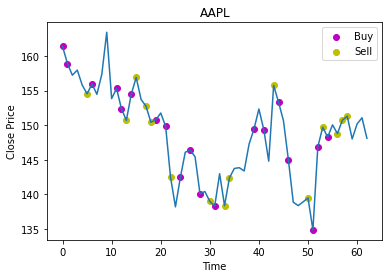

In [15]:
buy_index=[index for index,value in enumerate(actions) if value=='Buy']
sell_index=[index for index,value in enumerate(actions) if value=='Sell']
plt.plot(test_prices)
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(stock_name)
plt.scatter(buy_index,test_prices[buy_index],c='m',label='Buy')
plt.scatter(sell_index,test_prices[sell_index],c='y',label='Sell')
plt.legend()
baseline_reward=(test_prices[-1]-test_prices[0])*math.floor(budget/test_prices[0])
qlearning_reward=portfolio-budget
print(f'base line reward is {baseline_reward}')
print(f'Q-learning reward is {qlearning_reward}')

In [16]:
stock_name=stocks[2]
best_policy=get_best_policy(stock_name)[0]
test_prices=train_test_split(stock_name)[1]
actions = ['Sell', 'Buy', 'Hold']
hist = 3
budget = 10000*weights[stocks.index(stock_name)]
num_stocks = 0
portfolio,policy,actions=run_simulation(best_policy, budget, num_stocks, test_prices, hist)
print(portfolio)
print(actions)

$2232.9799842834473	0 shares
2232.9799842834473
$2295.429973602295	0 shares
2295.429973602295
$2230.3100051879883	0 shares
2230.3100051879883
$17.950000762939453	39 shares
3400.0300483703613
$2245.0400161743164	0 shares
2245.0400161743164
$2217.8100509643555	0 shares
2217.8100509643555
$2246.119945526123	0 shares
2246.119945526123
$2264.420021057129	0 shares
2264.420021057129
$2187.620002746582	0 shares
2187.620002746582
$2244.029998779297	0 shares
2244.029998779297
$2228.760021209717	0 shares
2228.760021209717
$2207.8499908447266	0 shares
2207.8499908447266
$2199.7999229431152	0 shares
2199.7999229431152
$2204.5999908447266	0 shares
2204.5999908447266
$796.1400108337402	28 shares
3224.3000450134277
$386.169979095459	34 shares
3334.6500205993652
$835.2800483703613	33 shares
3697.0400886535645
$2212.4600105285645	0 shares
2212.4600105285645
$2226.5199279785156	0 shares
2226.5199279785156
$2272.879951477051	0 shares
2272.879951477051
$1882.629997253418	4 shares
2196.909996032715
2196.909

base line reward is -160.75000762939453
Q-learning reward is 6.909996032714844


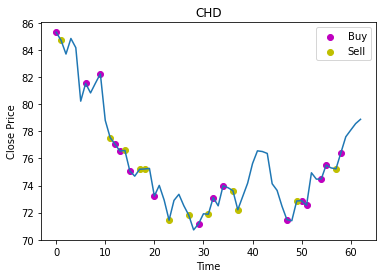

In [17]:
buy_index=[index for index,value in enumerate(actions) if value=='Buy']
sell_index=[index for index,value in enumerate(actions) if value=='Sell']
plt.plot(test_prices)
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(stock_name)
plt.scatter(buy_index,test_prices[buy_index],c='m',label='Buy')
plt.scatter(sell_index,test_prices[sell_index],c='y',label='Sell')
plt.legend()
baseline_reward=(test_prices[-1]-test_prices[0])*math.floor(budget/test_prices[0])
qlearning_reward=portfolio-budget
print(f'base line reward is {baseline_reward}')
print(f'Q-learning reward is {qlearning_reward}')

In [18]:
stock_name=stocks[3]
best_policy=get_best_policy(stock_name)[0]
test_prices=train_test_split(stock_name)[1]
actions = ['Sell', 'Buy', 'Hold']
hist = 3
budget = 10000*weights[stocks.index(stock_name)]
num_stocks = 0
portfolio,policy,actions=run_simulation(best_policy, budget, num_stocks, test_prices, hist)
print(portfolio)
print(actions)

$1464.8999176025388	0 shares
1464.8999176025388
$1668.6700439453123	0 shares
1668.6700439453123
$322.4199523925779	6 shares
2922.399871826172
$1486.7601318359373	0 shares
1486.7601318359373
$1603.3500976562498	0 shares
1603.3500976562498
$1676.6598968505857	0 shares
1676.6598968505857
$1277.0797576904295	5 shares
3443.729690551758
$1591.699981689453	0 shares
1591.699981689453
$1019.9701232910154	5 shares
3186.6200561523438
$41.05999755859352	9 shares
3941.0298767089844
$1928.3199462890623	0 shares
1928.3199462890623
$88.03010559082009	8 shares
3554.6699981689453
$112.92012023925759	8 shares
3579.560012817383
$1851.7500762939453	1 shares
2285.080062866211
$1092.1100463867188	4 shares
2825.4299926757812
$1660.8598175048826	0 shares
1660.8598175048826
$1660.490051269531	0 shares
1660.490051269531
$1511.9698333740232	0 shares
1511.9698333740232
$1586.5499420166013	0 shares
1586.5499420166013
$1871.610122680664	1 shares
2304.9401092529297
$173.61999511718727	3 shares
1539.8199768066404
1539

base line reward is 120.80996704101562
Q-learning reward is 119.81997680664062


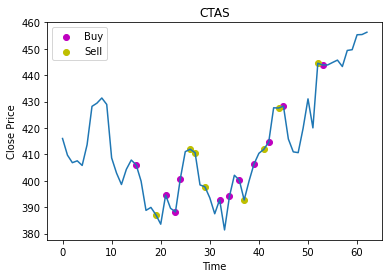

In [19]:
buy_index=[index for index,value in enumerate(actions) if value=='Buy']
sell_index=[index for index,value in enumerate(actions) if value=='Sell']
plt.plot(test_prices)
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(stock_name)
plt.scatter(buy_index,test_prices[buy_index],c='m',label='Buy')
plt.scatter(sell_index,test_prices[sell_index],c='y',label='Sell')
plt.legend()
baseline_reward=(test_prices[-1]-test_prices[0])*math.floor(budget/test_prices[0])
qlearning_reward=portfolio-budget
print(f'base line reward is {baseline_reward}')
print(f'Q-learning reward is {qlearning_reward}')

### reference

https://github.com/jbuckley213/Stock-Trader-Q-Learning